In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
plt.rc('font', family = "Malgun Gothic")
plt.style.use('ggplot')

In [2]:
# 최적 클러스터 개수 k를 찾기 위한 함수 
def Elbow(X):
    SSE = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        SSE.append(kmeans.inertia_)
        
    plt.plot(range(1,11), SSE, marker='o')
    plt.xlabel("# of clusters")
    plt.ylabel("SSE") #오차제곱합
    plt.title("Elbow Method for Optimal k")
    plt.show()

In [3]:
def kmeans(train_data, n):
    X = train_data[train_data["SVC_INDUTY_CD_NM"] == n]
    X = X.drop(n, axis=1)
    ## 최적 클러스터 개수 k 결정
    Elbow(X.iloc[:,2:])
    k = int(input("클러스터 개수 k를 입력하세요 : "))
    ## kmeans 군집화
    model = KMeans(n_clusters = k)
    model.fit(X.iloc[:,2:])
    X["cluster"] = model.labels_
    ## 군집 결과 시각화 
    plt.figure(figsize=(10, 5))
    X["cluster"].astype(str).hist()
    plt.xlabel("군집")
    plt.ylabel("개수")
    plt.title(n + " 군집 결과")
    plt.show()
    print(n + " 군집별 블록 개수")
    print(X["cluster"].value_counts())
    return X # 클러스터링한 데이터 프레임 return

In [6]:
def synergy_B(clusterN, svc_list):
    # clusterN는 군집별 데이터 프레임
    # svc_list는 다이나믹을 보고 싶은 업종 리스트
    temp = clusterN[["BLCK_CD"] + svc_list]
    temp.set_index("BLCK_CD", inplace=True)
    print("업종별 긍정적인 응집도 비율")
    for svc in svc_list:
        total_cnt = 0 # 업소의 개수
        good_cnt = 0  # 블록 매출액이 업종 매출액보다 큰 경우
        error_cnt = 0 # 매출액 정보가 없는 경우
        for blck in temp.index:
            if temp.loc[blck, svc] > 0:
                total_cnt += 1
                try:
                    if BLCK_SVC_AMT.loc[blck][svc] > SVC_AMT_B.loc[svc]:
                        good_cnt +=1  
                except TypeError:
                    error_cnt += 1
                except KeyError:
                    error_cnt += 1
        ## 긍정적인 응집도 비율
        if total_cnt == error_cnt: # 매출액 데이터가 하나도 없는 업종
            print(svc, 0) 
        else: # 긍정적인 응집도
            print(svc, round(good_cnt/(total_cnt-error_cnt)*100, 2))  
            

In [22]:
def synergy_check(q,cluster,size=(8,5)):
    dic_1 ={}
    #q =["한식음식점","노래방","호프-간이주점","커피-음료"]
    df1 = GANGBUK_AMT_2.loc[cluster["BLCK_CD"].values] #파워업종이 한식음식점인 블록
    df2 = GANGBUK_AMT_2.drop(cluster["BLCK_CD"].values,axis=0) #파워업종이 한식음식점이 아닌 블록
    for k in q:
        dic_1[k]=(df1[df1["SVC_INDUTY_CD_NM"]==k].mean()["AMT"],df2[df2["SVC_INDUTY_CD_NM"]==k].mean()["AMT"])
    final_df=pd.DataFrame(dic_1).T
    final_df.columns=["Power","Nonpower"]
    x = np.arange(len(q))
    plt.figure(figsize=size)
    plt.title(q[0]+"과 시너지 효과를 내는 업종")
    plt.bar(x-0.0,final_df["Power"],width=0.2,label="파워업종")
    plt.bar(x+0.2,final_df["Nonpower"],width=0.2,label='파워업종X')
    plt.xticks(x,q)
    plt.legend()
    plt.xlabel("업종")
    plt.ylabel("평균매출액")
    plt.show()

# 1. 데이터 불러오기

In [8]:
gangbuk = pd.read_csv("buk_good_df.csv",encoding='utf-8-sig')
gangbuk

,BLCK_CD,SVC_INDUTY_CD_NM,RATIO_SCORE,count
0,169513,한식음식점,3.102969,135
1,213447,한식음식점,2.643528,135
2,213458,한식음식점,3.272755,135
3,213460,한식음식점,3.929401,135
4,213464,한식음식점,1.365214,135
...,...,...,...,...
468,220516,한의원,2.926953,10
469,220551,한의원,1.965905,10
470,220846,한의원,2.236375,10
471,221165,한의원,1.663684,10


## 1.1 블록별 업종별 업소 개수

In [7]:
SVC = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SVC_INDUTY_MAPNG_NEW.csv",sep="|") # 업종매핑 테이블
SVC.head()

,SVC_INDUTY_CD,SVC_INDUTY_CD_NM,INDUTY_CD,INDUTY_CD_NM
0,CS100001,한식음식점,56111,한식 음식점업
1,CS100002,중식음식점,56112,중식 음식점업
2,CS100003,일식음식점,56113,일식 음식점업
3,CS100004,양식음식점,56114,서양식 음식점업
4,CS100004,양식음식점,56119,기타 외국식 음식점업


In [9]:
SVC_CODE = SVC["SVC_INDUTY_CD_NM"].unique()
SVC_CODE # 100개의 업종

array(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점',
       '분식전문점', '호프-간이주점', '커피-음료', '일반교습학원', '외국어학원', '예술학원', '컴퓨터학원',
       '스포츠 강습', '일반의원', '치과의원', '한의원', '동물병원', '변호사사무소', '변리사사무소',
       '법무사사무소', '기타법무서비스', '회계사사무소', '세무사사무소', '당구장', '골프연습장', '볼링장',
       'PC방', '전자게임장', '기타오락장', '복권방', '통신기기수리', '스포츠클럽', '자동차수리',
       '자동차미용', '모터사이클수리', '미용실', '네일숍', '피부관리실', '세탁소', '가전제품수리',
       '부동산중개업', '여관', '게스트하우스', '고시원', '노래방', '독서실', 'DVD방', '녹음실',
       '사진관', '통번역서비스', '건축물청소', '여행사', '비디오/서적임대', '의류임대', '가정용품임대',
       '슈퍼마켓', '편의점', '컴퓨터및주변장치판매', '핸드폰', '주류도매', '미곡판매', '육류판매',
       '수산물판매', '청과상', '반찬가게', '일반의류', '한복점', '유아의류', '신발', '가방', '안경',
       '시계및귀금속', '의약품', '의료기기', '서적', '문구', '화장품', '미용재료', '운동/경기용품',
       '자전거 및 기타운송장비', '완구', '섬유제품', '화초', '애완동물', '중고가구', '가구', '가전제품',
       '철물점', '악기', '인테리어', '조명용품', '중고차판매', '자동차부품', '모터사이클및부품',
       '재생용품 판매점', '예술품', '주유소', '전자상거래업'], dtype=object)

In [10]:
CNFM_FINAL = pd.read_csv("CNFM_FINAL.csv") # 업소정보 테이블 (unique)
CNFM_FINAL.head()

,STDR_YM_CD,STOR_INNB,STOR_NM,SVC_INDUTY_CD,OPBIZ_YM,CLSBIZ_YM,OLD_ADRES,NW_ADRES,TELNO,BLCK_CD,HOUS_ID,PROC_CLSS,DW_REGIST_DT,ROAD_CD,XCNTS_VALUE,YDNTS_VALUE,FRC_YN,STD_INDCLS_INDUTY_CD,BIZ_MNTH
0,201906,1004015113,한***,NaN,2007-04-01,2019-12-31,NaN,NaN,02)904-6694,219851,390002,NaN,17-SEP-19,NaN,201935.0,460279.0,N,28423,153
1,201906,1003767731,사********,NaN,2010-07-01,2019-12-31,NaN,NaN,02)518-1779,132329,1090000,NaN,17-SEP-19,NaN,203387.0,446580.0,N,46433,114
2,201906,1003768050,동*****,NaN,2010-03-01,2019-12-31,NaN,NaN,NaN,30757,0,NaN,17-SEP-19,NaN,202741.0,446136.0,N,75120,118
3,201906,1004582176,대*****,NaN,2014-06-01,2019-12-31,NaN,NaN,02)552-6696,350525,1130004,NaN,17-SEP-19,NaN,204129.0,445699.0,N,45219,67
4,201906,1003262158,보*****,NaN,2014-08-01,2019-12-31,NaN,NaN,02)6010-1004,30542,1870016,NaN,17-SEP-19,NaN,202428.0,445248.0,N,96991,65


In [11]:
BLCK_SVC = pd.merge(CNFM_FINAL,SVC,left_on ="STD_INDCLS_INDUTY_CD",right_on="INDUTY_CD")
BLCK_SVC_CNT = BLCK_SVC.groupby(["BLCK_CD","SVC_INDUTY_CD_NM"])["SVC_INDUTY_CD_NM"].count().unstack()
BLCK_SVC_CNT = BLCK_SVC_CNT.fillna(0)
BLCK_SVC_CNT.reset_index(inplace=True)
BLCK_SVC_CNT # 블록별 업종별 업소 개수 

SVC_INDUTY_CD_NM,BLCK_CD,DVD방,PC방,가구,가방,가전제품,가전제품수리,가정용품임대,건축물청소,게스트하우스,...,편의점,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소
0,118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,502557,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4339,502558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4340,502597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4341,502807,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0


## 1.2 블록별 업종별 평균 매출액

In [12]:
SELNG = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SELNG.csv",sep="|") # 매출금액
SELNG.head()

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,RCNT_60,MCT_SALES,NEW_MCT,P1_M6,P1_1Y,P1_2Y,P1_3Y,P1_4Y,P1_5Y,P1_6Y
0,10019,201701,47413,1,5000000,1,5000000,1,5000000,1,...,0,25,0,0,0,0,1,0,0,0
1,10019,201701,47416,1,20158000,15,20158000,15,20158000,15,...,1,130,0,0,0,0,0,0,0,1
2,10019,201701,47420,1,1429000,3,1429000,3,1429000,3,...,0,19,0,0,0,1,0,0,0,0
3,10019,201701,47811,1,12668290,706,12668290,706,12668290,706,...,33,101,0,0,0,0,0,0,0,1
4,10019,201701,47813,1,4000000,1,4000000,1,4000000,1,...,0,13,0,0,0,1,0,0,0,0


In [13]:
SELNG_DEC = SELNG[SELNG["TA_YM"] == 201912] # 2019년 12월 매출액만 가져오기
SELNG_DEC_SVC = SELNG_DEC.merge(SVC, left_on="KSIC_CD", right_on="INDUTY_CD")

In [14]:
BLCK_SVC_AMT = SELNG_DEC_SVC.groupby(["BLCK_CD","SVC_INDUTY_CD_NM"])["AMT"].mean()
BLCK_SVC_AMT # 블록별 업종별 평균 매출액

BLCK_CD  SVC_INDUTY_CD_NM
118      노래방                   1821000.0
         커피-음료                 1002400.0
         편의점                   6860940.0
         한식음식점                 1421000.0
         호프-간이주점               1145900.0
                                ...     
502813   편의점                 107179269.0
         피부관리실                  612000.0
         한식음식점                 2346600.0
         한의원                   1567200.0
         화초                     625000.0
Name: AMT, Length: 21425, dtype: float64

In [15]:
AMT_MAPNG = BLCK_SVC_AMT.unstack()
AMT_MAPNG

SVC_INDUTY_CD_NM,DVD방,PC방,가구,가방,가전제품,가전제품수리,가정용품임대,건축물청소,게스트하우스,고시원,...,편의점,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소
BLCK_CD,,,,,,,,,,,,,,,,,,,,,
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6860940.0,NaN,NaN,1421000.0,NaN,NaN,1145900.0,NaN,NaN,NaN
164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,62792771.0,NaN,NaN,NaN,NaN,NaN,NaN
502557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7907190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
SIGNGU = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SIGNGU_DIM.csv",sep="|") # 시군구정보
BLCK_DIM = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/BLCK_DIM.csv",sep="|") # 블록영역정보
SIGNGU_CD_DF = pd.merge(SIGNGU,BLCK_DIM,on="SIGNGU_CD")
GANGBUK_CD = BLCK_DIM[BLCK_DIM["SIGNGU_CD"]==11305].iloc[:,[0]] #2419
SVC_AMT_B=pd.merge(SELNG_DEC_SVC,GANGBUK_CD,on="BLCK_CD").groupby("SVC_INDUTY_CD_NM").mean()["AMT"] # 강북구 업종별 평균 매출액
GANGBUK_AMT_2= pd.merge(SELNG_DEC_SVC,GANGBUK_CD,on="BLCK_CD").iloc[:,[0,1,2,4,-4,]]
GANGBUK_AMT_2.index = GANGBUK_AMT_2["BLCK_CD"]

# 1. 강북구 군집화

## 1.1 데이터 전처리

In [17]:
gangbuk_train = gangbuk[["BLCK_CD","SVC_INDUTY_CD_NM"]]
gangbuk_train

,BLCK_CD,SVC_INDUTY_CD_NM
0,169513,한식음식점
1,213447,한식음식점
2,213458,한식음식점
3,213460,한식음식점
4,213464,한식음식점
...,...,...
468,220516,한의원
469,220551,한의원
470,220846,한의원
471,221165,한의원


In [18]:
gangbuk_train = gangbuk_train.merge(BLCK_SVC_CNT, how="left", left_on="BLCK_CD", right_on="BLCK_CD")

In [19]:
# 군집화의 성능 향상을 위해, 컬럼별로 0의 비율 구한 뒤 제거하기
ZERO_RATIO = gangbuk_train.isin([0]).sum()/len(gangbuk_train)*100
ZERO_RATIO = ZERO_RATIO[2:]
ZERO_DROP = list(ZERO_RATIO[ZERO_RATIO.values>ZERO_RATIO.describe()["75%"]].index) #89%
gangbuk_train = gangbuk_train.drop(ZERO_DROP,axis=1)
gangbuk_train #473*78

,BLCK_CD,SVC_INDUTY_CD_NM,PC방,가구,가방,가전제품,가전제품수리,골프연습장,기타법무서비스,기타오락장,...,컴퓨터및주변장치판매,패스트푸드점,편의점,피부관리실,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초
0,169513,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
1,213447,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0
2,213458,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0
3,213460,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0
4,213464,한식음식점,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,6.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,220516,한의원,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,2.0,0.0,3.0,1.0,0.0
469,220551,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0
470,220846,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
471,221165,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0


In [20]:
gangbuk_train["SVC_INDUTY_CD_NM"].value_counts()

한식음식점      135
슈퍼마켓        45
편의점         40
일반의원        37
의약품         30
육류판매        26
치과의원        22
호프-간이주점     21
자동차수리       20
미용실         20
치킨전문점       20
일반의류        15
주유소         11
제과점         11
중식음식점       10
한의원         10
Name: SVC_INDUTY_CD_NM, dtype: int64

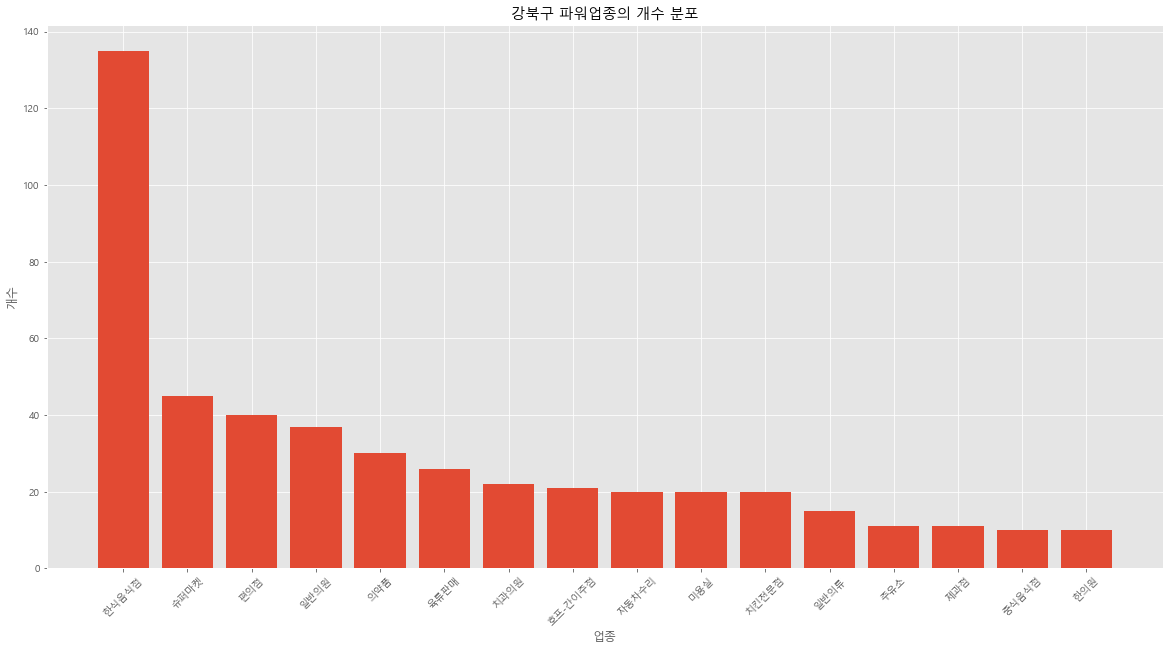

In [21]:
X = gangbuk_train["SVC_INDUTY_CD_NM"].value_counts().index
Y = gangbuk_train["SVC_INDUTY_CD_NM"].value_counts().values
plt.figure(figsize=(20, 10))
plt.bar(X,Y)
plt.xticks(rotation=45)
plt.xlabel("업종")
plt.ylabel("개수")
plt.title("강북구 파워업종의 개수 분포")
plt.show()

## 1.2 군집화 및 시각화

### 1) 강북구 한식음식점

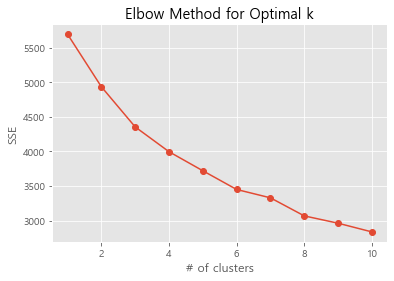

클러스터 개수 k를 입력하세요 : 6


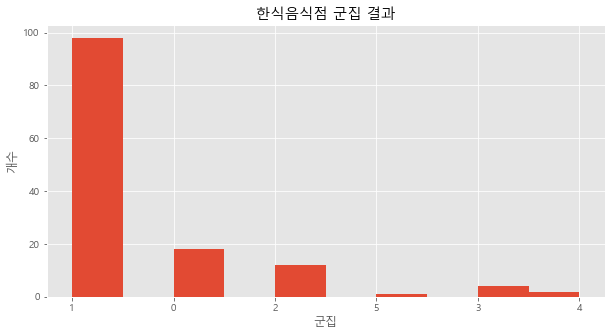

한식음식점 군집별 블록 개수
1    98
0    18
2    12
3     4
4     2
5     1
Name: cluster, dtype: int64


In [80]:
Y1 = kmeans(gangbuk_train, "한식음식점")

In [153]:
## 강북구 한식음식점 1번 군집
cluster0, svc_list = clusterN(Y1,1)
synergy_B(cluster0, svc_list)

군집 1 업종의 개수 분포
count    75.000000
mean      0.199456
std       0.220354
min       0.000000
25%       0.061224
50%       0.122449
75%       0.244898
max       1.081633
dtype: float64


,BLCK_CD,미용실
0,169513,1.0
1,213447,2.0
2,213458,0.0
3,213460,0.0
4,213464,2.0
...,...,...
129,221578,0.0
130,338554,0.0
131,338568,2.0
132,409567,0.0


업종별 긍정적인 응집도 비율
미용실 23.33


In [206]:
## 강북구 한식음식점 0번 군집
cluster0, svc_list = clusterN(Y1,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.315556
std       0.667302
min       0.000000
25%       0.027778
50%       0.111111
75%       0.333333
max       4.777778
dtype: float64


,BLCK_CD,노래방,분식전문점,일반의류,커피-음료,호프-간이주점
8,218496,1.0,0.0,0.0,0.0,4.0
10,218667,4.0,1.0,1.0,5.0,1.0
29,219573,0.0,0.0,1.0,1.0,5.0
31,219599,2.0,1.0,1.0,1.0,7.0
32,219604,1.0,0.0,2.0,4.0,4.0
38,219880,7.0,1.0,2.0,1.0,3.0
48,220117,4.0,0.0,0.0,1.0,6.0
52,220140,4.0,1.0,2.0,1.0,4.0
68,220714,4.0,4.0,1.0,3.0,4.0
69,220720,4.0,1.0,2.0,0.0,7.0


업종별 긍정적인 응집도 비율
노래방 64.29
분식전문점 38.46
일반의류 16.67
커피-음료 50.0
호프-간이주점 55.56


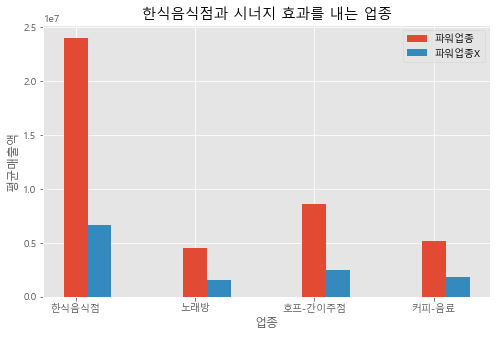

In [207]:
synergy_check(["한식음식점","노래방","호프-간이주점","커피-음료"],cluster0)

In [210]:
cluster0["BLCK_CD"].values

array([218496, 218667, 219573, 219599, 219604, 219880, 220117, 220140,
       220714, 220720, 220721, 221075, 221121, 221280, 219031, 219299,
       220132, 220501], dtype=int64)

In [211]:
## 강북구 한식음식점 2번 군집
cluster2, svc_list = clusterN(Y1,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.495556
std       0.706296
min       0.000000
25%       0.083333
50%       0.250000
75%       0.666667
max       4.500000
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,여관,일반의류,커피-음료,피부관리실,호프-간이주점,화장품
12,218961,1.0,2.0,1.0,1.0,6.0,0.0,0.0,2.0,2.0
26,219550,0.0,0.0,3.0,0.0,15.0,0.0,0.0,0.0,3.0
47,220109,1.0,6.0,1.0,2.0,4.0,4.0,2.0,2.0,1.0
53,220149,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,8.0
54,220154,1.0,2.0,1.0,3.0,4.0,0.0,6.0,2.0,7.0
58,220450,1.0,2.0,1.0,7.0,2.0,0.0,1.0,0.0,1.0
89,338618,3.0,3.0,0.0,0.0,8.0,3.0,0.0,1.0,0.0
92,215851,0.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0
115,220152,0.0,7.0,1.0,0.0,3.0,2.0,0.0,2.0,1.0
118,220423,4.0,5.0,2.0,5.0,3.0,1.0,2.0,1.0,0.0


업종별 긍정적인 응집도 비율
미용실 62.5
부동산중개업 0
분식전문점 0.0
여관 50.0
일반의류 36.36
커피-음료 71.43
피부관리실 75.0
호프-간이주점 16.67
화장품 40.0


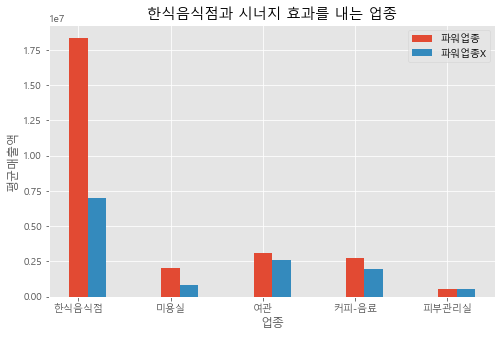

In [212]:
synergy_check(["한식음식점","미용실","여관","커피-음료","피부관리실"],cluster2)

In [213]:
cluster2["BLCK_CD"].values

array([218961, 219550, 220109, 220149, 220154, 220450, 338618, 215851,
       220152, 220423, 220427, 410193], dtype=int64)

### 2. 강북구 슈퍼마켓

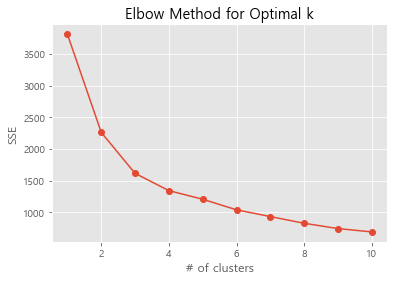

클러스터 개수 k를 입력하세요 : 3


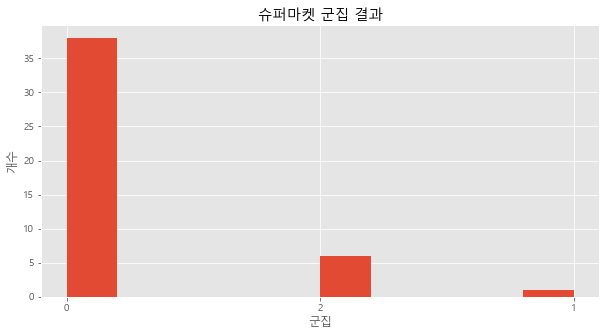

슈퍼마켓 군집별 블록 개수
0    38
2     6
1     1
Name: cluster, dtype: int64


In [171]:
Y2 = kmeans(gangbuk_train, "슈퍼마켓")

In [172]:
#강북구 슈퍼마켓 0번째 군집
cluster0, svc_list = clusterN(Y2,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.230175
std       0.318536
min       0.000000
25%       0.052632
50%       0.131579
75%       0.302632
max       2.105263
dtype: float64


,BLCK_CD,미용실,부동산중개업,한식음식점
166,213466,3.0,0.0,3.0
167,213476,0.0,0.0,0.0
170,216434,1.0,1.0,0.0
171,218641,2.0,0.0,4.0
173,218913,1.0,1.0,0.0
174,218945,0.0,2.0,0.0
175,218992,0.0,0.0,3.0
176,219040,1.0,0.0,1.0
177,219304,0.0,0.0,2.0
178,219451,1.0,0.0,2.0


업종별 긍정적인 응집도 비율
미용실 21.74
부동산중개업 0
한식음식점 17.86


In [215]:
#강북구 슈퍼마켓 2번째 군집
cluster2, svc_list = clusterN(Y2,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.951111
std       1.304524
min       0.000000
25%       0.166667
50%       0.500000
75%       1.166667
max       7.500000
dtype: float64


,BLCK_CD,노래방,미용실,반찬가게,부동산중개업,분식전문점,스포츠 강습,시계및귀금속,안경,외국어학원,...,제과점,치과의원,커피-음료,패스트푸드점,피부관리실,한식음식점,한의원,핸드폰,호프-간이주점,화장품
168,215859,0.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,1.0,...,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,4.0
169,216090,3.0,1.0,3.0,3.0,7.0,2.0,3.0,1.0,0.0,...,1.0,1.0,1.0,4.0,1.0,19.0,1.0,1.0,4.0,1.0
172,218652,2.0,2.0,0.0,3.0,4.0,1.0,0.0,3.0,1.0,...,1.0,2.0,7.0,3.0,9.0,6.0,2.0,2.0,1.0,5.0
181,219568,0.0,6.0,3.0,7.0,7.0,2.0,0.0,0.0,4.0,...,3.0,0.0,4.0,0.0,2.0,3.0,0.0,0.0,1.0,1.0
186,219899,0.0,3.0,1.0,0.0,3.0,4.0,1.0,0.0,3.0,...,1.0,1.0,3.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0
190,220407,2.0,2.0,3.0,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,3.0,0.0,1.0,3.0,5.0,2.0,2.0,1.0,0.0


업종별 긍정적인 응집도 비율
노래방 0.0
미용실 60.0
반찬가게 50.0
부동산중개업 0
분식전문점 50.0
스포츠 강습 60.0
시계및귀금속 50.0
안경 25.0
외국어학원 50.0
육류판매 100.0
의약품 75.0
일반교습학원 66.67
일반의류 33.33
일반의원 75.0
제과점 25.0
치과의원 25.0
커피-음료 66.67
패스트푸드점 66.67
피부관리실 50.0
한식음식점 33.33
한의원 75.0
핸드폰 0.0
호프-간이주점 33.33
화장품 33.33


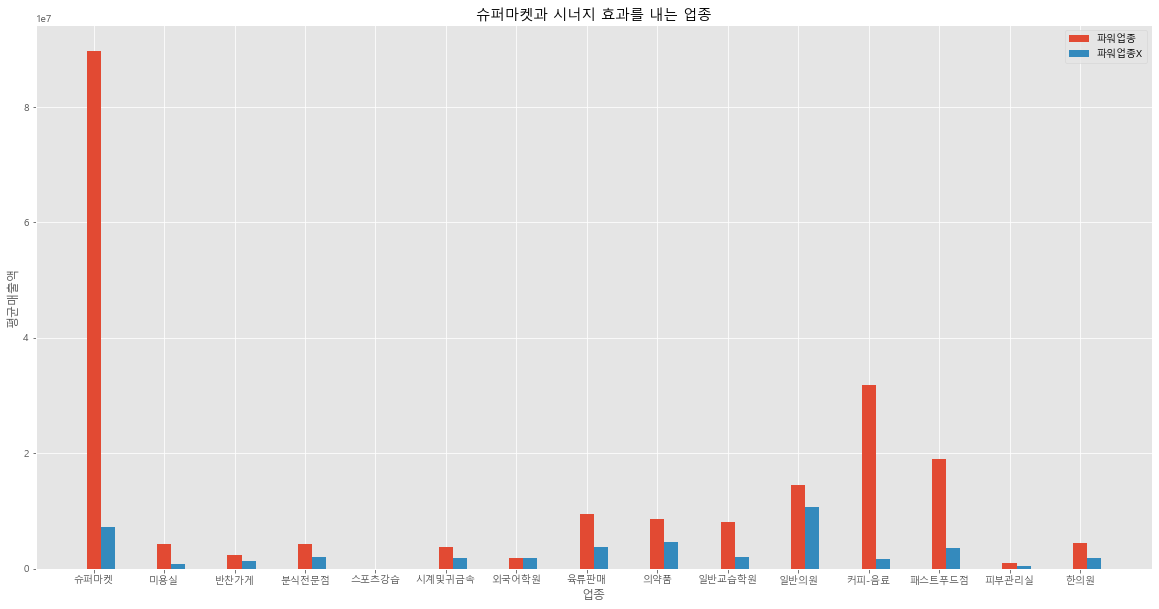

In [182]:
synergy_check(["슈퍼마켓","미용실","반찬가게","분식전문점","스포츠강습","시계및귀금속","외국어학원","육류판매","의약품","일반교습학원","일반의원","커피-음료","패스트푸드점","피부관리실","한의원"],cluster2,size=(20,10))

In [216]:
cluster2["BLCK_CD"].values

array([215859, 216090, 218652, 219568, 219899, 220407], dtype=int64)

### 3. 강북구 편의점

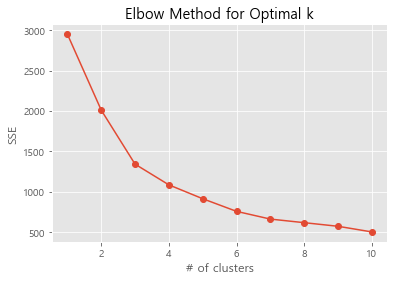

클러스터 개수 k를 입력하세요 : 4


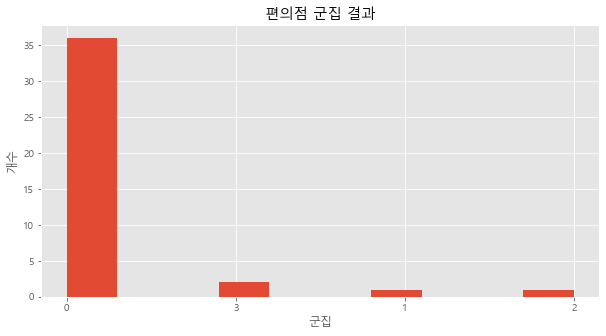

편의점 군집별 블록 개수
0    36
3     2
2     1
1     1
Name: cluster, dtype: int64


In [183]:
Y3 = kmeans(gangbuk_train, "편의점")

In [184]:
#강북구 편의점 0번째 군집
cluster0, svc_list = clusterN(Y3,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.230370
std       0.326116
min       0.000000
25%       0.055556
50%       0.111111
75%       0.277778
max       2.000000
dtype: float64


,BLCK_CD,미용실,부동산중개업,한식음식점
300,216359,1.0,0.0,2.0
301,216416,0.0,3.0,2.0
302,216417,3.0,1.0,0.0
303,218991,0.0,3.0,5.0
304,219195,2.0,2.0,1.0
305,219279,1.0,1.0,0.0
306,219510,2.0,0.0,2.0
307,219770,1.0,0.0,1.0
308,219840,0.0,0.0,1.0
309,219874,1.0,0.0,2.0


업종별 긍정적인 응집도 비율
미용실 10.0
부동산중개업 0
한식음식점 14.81


### 4. 강북구 일반의원

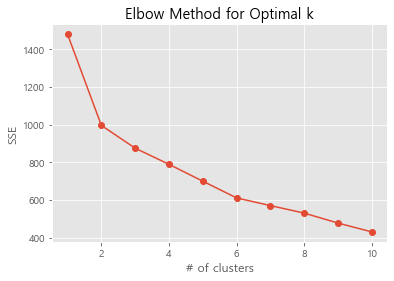

클러스터 개수 k를 입력하세요 : 3


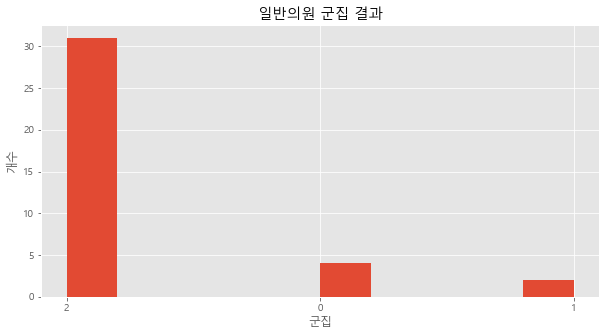

일반의원 군집별 블록 개수
2    31
0     4
1     2
Name: cluster, dtype: int64


In [185]:
Y4 = kmeans(gangbuk_train,"일반의원")

In [186]:
#강북구 일반의원 2번째 군집
cluster2, svc_list = clusterN(Y4,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.230968
std       0.271296
min       0.000000
25%       0.064516
50%       0.129032
75%       0.290323
max       1.419355
dtype: float64


,BLCK_CD,의약품,한식음식점
401,218669,0.0,0.0
402,218970,1.0,3.0
403,219495,1.0,1.0
404,219547,1.0,1.0
405,219659,0.0,1.0
406,219854,0.0,2.0
407,219858,1.0,1.0
408,219934,0.0,1.0
409,220155,2.0,0.0
410,220267,0.0,1.0


업종별 긍정적인 응집도 비율
의약품 20.83
한식음식점 4.17


In [217]:
#강북구 일반의원 0번째 군집
cluster0, svc_list = clusterN(Y4,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.366667
std       0.855559
min       0.000000
25%       0.000000
50%       0.250000
75%       0.375000
max       6.750000
dtype: float64


,BLCK_CD,미용실,부동산중개업,의약품,일반의류,일식음식점,한식음식점,호프-간이주점
413,220427,1.0,0.0,2.0,5.0,0.0,11.0,2.0
420,213458,0.0,3.0,1.0,0.0,1.0,4.0,3.0
430,219918,1.0,1.0,0.0,1.0,2.0,6.0,1.0
432,220490,2.0,2.0,2.0,0.0,1.0,6.0,3.0


업종별 긍정적인 응집도 비율
미용실 100.0
부동산중개업 0
의약품 66.67
일반의류 100.0
일식음식점 33.33
한식음식점 100.0
호프-간이주점 25.0


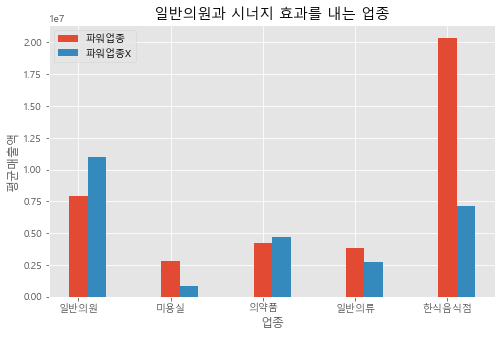

In [218]:
synergy_check(["일반의원","미용실","의약품","일반의류","한식음식점"],cluster0)

In [219]:
cluster0["BLCK_CD"].values

array([220427, 213458, 219918, 220490], dtype=int64)

### 5. 호프-간이주점

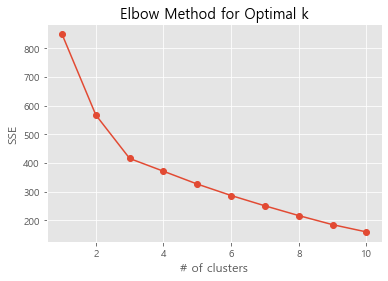

클러스터 개수 k를 입력하세요 : 3


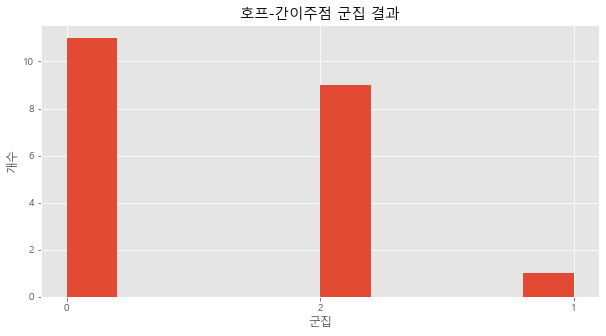

호프-간이주점 군집별 블록 개수
0    11
2     9
1     1
Name: cluster, dtype: int64


In [189]:
Y5 = kmeans(gangbuk_train, "호프-간이주점")

In [190]:
#강북구 호프-간이주점 0번째 군집
cluster0, svc_list = clusterN(Y5,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.198788
std       0.242232
min       0.000000
25%       0.000000
50%       0.090909
75%       0.272727
max       1.090909
dtype: float64


,BLCK_CD,미용실
380,216423,1.0
381,218963,1.0
383,219740,1.0
387,220913,2.0
388,216049,0.0
389,216359,1.0
390,216432,2.0
391,219257,3.0
392,219304,0.0
393,219840,0.0


업종별 긍정적인 응집도 비율
미용실 0.0


In [220]:
#강북구 호프-간이주점 2번째 군집
cluster2, svc_list = clusterN(Y5,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.320000
std       0.758438
min       0.000000
25%       0.000000
50%       0.111111
75%       0.333333
max       6.000000
dtype: float64


,BLCK_CD,노래방,분식전문점,커피-음료,편의점,한식음식점
382,219585,1.0,0.0,1.0,0.0,6.0
384,220055,3.0,0.0,1.0,4.0,6.0
385,220132,2.0,5.0,1.0,2.0,4.0
386,220501,2.0,2.0,1.0,1.0,3.0
394,220117,4.0,0.0,1.0,0.0,10.0
397,220713,3.0,1.0,2.0,1.0,6.0
398,220727,0.0,2.0,0.0,1.0,9.0
399,220825,0.0,1.0,2.0,0.0,6.0
400,221121,0.0,1.0,5.0,0.0,4.0


업종별 긍정적인 응집도 비율
노래방 50.0
분식전문점 50.0
커피-음료 42.86
편의점 80.0
한식음식점 66.67


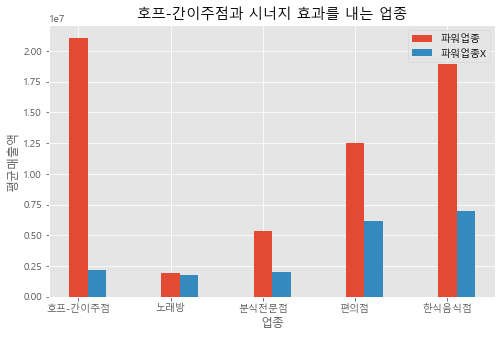

In [221]:
synergy_check(["호프-간이주점","노래방","분식전문점","편의점","한식음식점"],cluster2)

In [222]:
cluster2["BLCK_CD"].values

array([219585, 220055, 220132, 220501, 220117, 220713, 220727, 220825,
       221121], dtype=int64)

### 6. 강북구 미용실

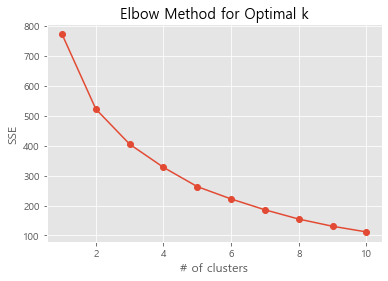

클러스터 개수 k를 입력하세요 : 4


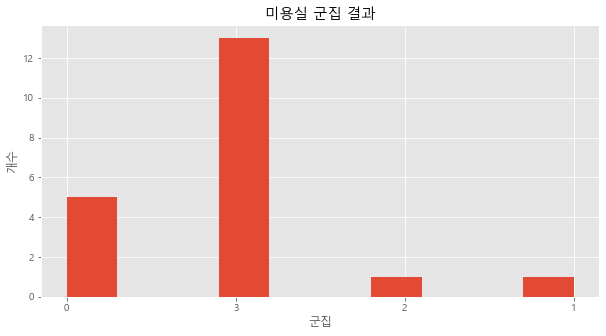

미용실 군집별 블록 개수
3    13
0     5
2     1
1     1
Name: cluster, dtype: int64


In [193]:
Y6 = kmeans(gangbuk_train,"미용실")

In [194]:
#강북구 미용실 3번째 군집
cluster3, svc_list = clusterN(Y6,3)
synergy_B(cluster3, svc_list)

군집 3 업종의 개수 분포
count    75.000000
mean      0.170256
std       0.252381
min       0.000000
25%       0.000000
50%       0.076923
75%       0.230769
max       1.615385
dtype: float64


,BLCK_CD,한식음식점
362,213447,4.0
363,213472,2.0
364,216417,0.0
365,219007,1.0
366,219279,0.0
367,219289,3.0
368,219309,3.0
369,219454,4.0
371,219690,0.0
372,219759,1.0


업종별 긍정적인 응집도 비율
한식음식점 22.22


In [223]:
#강북구 미용실 0번째 군집
cluster0, svc_list = clusterN(Y6,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.250667
std       0.672304
min       0.000000
25%       0.000000
50%       0.000000
75%       0.200000
max       4.400000
dtype: float64


,BLCK_CD,노래방,부동산중개업,여관,일반의류,치킨전문점,한식음식점,호프-간이주점
360,216411,1.0,3.0,0.0,1.0,2.0,7.0,3.0
361,219299,0.0,3.0,0.0,4.0,0.0,3.0,6.0
373,219933,1.0,0.0,4.0,0.0,1.0,4.0,2.0
377,220731,4.0,0.0,6.0,0.0,2.0,1.0,1.0
378,220877,1.0,0.0,1.0,0.0,0.0,7.0,1.0


업종별 긍정적인 응집도 비율
노래방 0.0
부동산중개업 0
여관 66.67
일반의류 0.0
치킨전문점 66.67
한식음식점 40.0
호프-간이주점 0.0


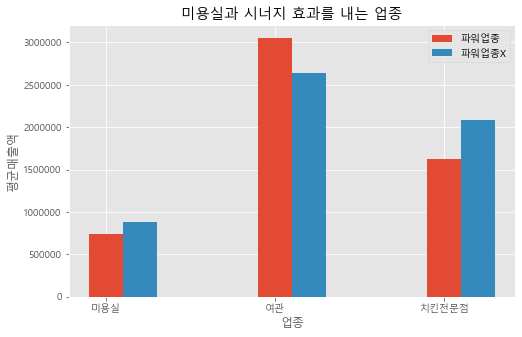

In [224]:
synergy_check(["미용실","여관","치킨전문점"],cluster0)

### 7. 강북구 치킨전문점

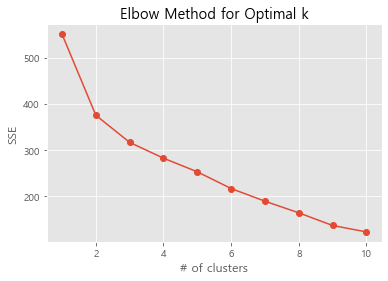

클러스터 개수 k를 입력하세요 : 3


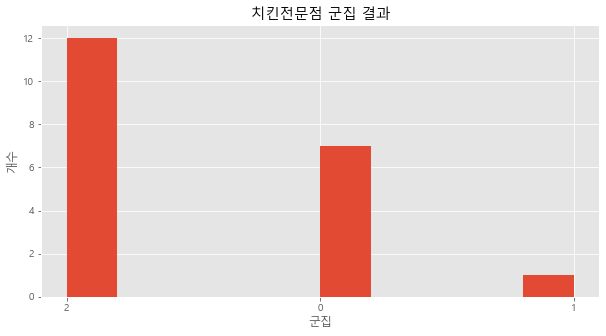

치킨전문점 군집별 블록 개수
2    12
0     7
1     1
Name: cluster, dtype: int64


In [24]:
Y7 = kmeans(gangbuk_train, "치킨전문점")

In [25]:
#강북구 치킨전문점 0번째 군집
cluster0, svc_list = clusterN(Y7,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.251429
std       0.517131
min       0.000000
25%       0.000000
50%       0.142857
75%       0.285714
max       3.428571
dtype: float64


,BLCK_CD,노래방,분식전문점,일반의류,한식음식점
136,215886,2.0,1.0,3.0,3.0
138,216378,2.0,0.0,1.0,4.0
139,218953,1.0,1.0,0.0,6.0
144,216118,0.0,0.0,4.0,3.0
145,216413,1.0,2.0,2.0,5.0
149,220045,0.0,3.0,4.0,2.0
151,221049,1.0,0.0,3.0,1.0


업종별 긍정적인 응집도 비율
노래방 20.0
분식전문점 0.0
일반의류 33.33
한식음식점 28.57


In [26]:
#강북구 치킨전문점 2번째 군집
cluster2, svc_list = clusterN(Y7,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.195556
std       0.293029
min       0.000000
25%       0.000000
50%       0.083333
75%       0.250000
max       1.333333
dtype: float64


,BLCK_CD,노래방,미용실,분식전문점,한식음식점,호프-간이주점
135,213444,1.0,2.0,1.0,2.0,0.0
137,216049,1.0,0.0,2.0,0.0,3.0
140,219076,0.0,2.0,0.0,2.0,2.0
141,219759,0.0,1.0,0.0,1.0,0.0
143,220426,2.0,0.0,0.0,2.0,2.0
146,219063,1.0,1.0,0.0,0.0,1.0
147,219102,2.0,1.0,3.0,0.0,2.0
148,219802,3.0,0.0,2.0,1.0,3.0
150,220716,2.0,3.0,1.0,3.0,1.0
152,410690,0.0,1.0,0.0,0.0,0.0


업종별 긍정적인 응집도 비율
노래방 0.0
미용실 12.5
분식전문점 0.0
한식음식점 14.29
호프-간이주점 0.0


### 8. 강북구 의약품

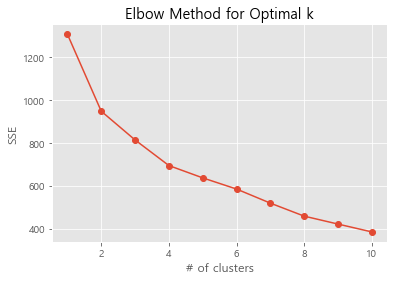

클러스터 개수 k를 입력하세요 : 4


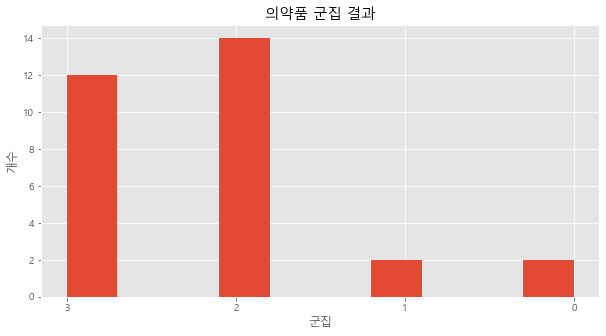

의약품 군집별 블록 개수
2    14
3    12
1     2
0     2
Name: cluster, dtype: int64


In [201]:
Y8 = kmeans(gangbuk_train, "의약품")

In [203]:
#강북구 의약품 2번째 군집
cluster2, svc_list = clusterN(Y8,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.203810
std       0.234178
min       0.000000
25%       0.000000
50%       0.142857
75%       0.285714
max       1.000000
dtype: float64


,BLCK_CD,일반의원
249,216365,1.0
251,219041,1.0
252,219295,0.0
253,219448,1.0
254,219801,1.0
258,220282,2.0
261,221589,1.0
262,410688,1.0
263,216381,1.0
264,218913,0.0


업종별 긍정적인 응집도 비율
일반의원 25.0


In [225]:
#강북구 의약품 3번째 군집
cluster3, svc_list = clusterN(Y8,3)
synergy_B(cluster3, svc_list)

군집 3 업종의 개수 분포
count    75.000000
mean      0.383333
std       0.614209
min       0.000000
25%       0.083333
50%       0.166667
75%       0.416667
max       4.500000
dtype: float64


,BLCK_CD,노래방,미용실,부동산중개업,분식전문점,일반의류,치킨전문점,한식음식점,호프-간이주점
248,216345,2.0,2.0,1.0,0.0,1.0,3.0,3.0,0.0
250,218971,0.0,0.0,1.0,4.0,0.0,0.0,5.0,1.0
257,220178,0.0,3.0,1.0,0.0,1.0,0.0,4.0,1.0
259,220722,1.0,1.0,1.0,0.0,1.0,2.0,3.0,2.0
260,221105,1.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0
265,218961,4.0,1.0,2.0,1.0,6.0,2.0,4.0,2.0
270,219560,0.0,1.0,0.0,0.0,1.0,0.0,6.0,1.0
271,219751,2.0,4.0,2.0,0.0,1.0,5.0,6.0,0.0
273,220084,1.0,3.0,2.0,3.0,2.0,0.0,5.0,2.0
274,220470,0.0,1.0,2.0,0.0,2.0,1.0,4.0,3.0


업종별 긍정적인 응집도 비율
노래방 66.67
미용실 27.27
부동산중개업 0
분식전문점 20.0
일반의류 0.0
치킨전문점 60.0
한식음식점 50.0
호프-간이주점 12.5


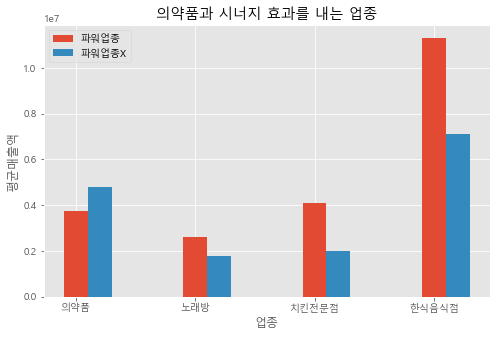

In [226]:
synergy_check(["의약품","노래방","치킨전문점","한식음식점"],cluster3)